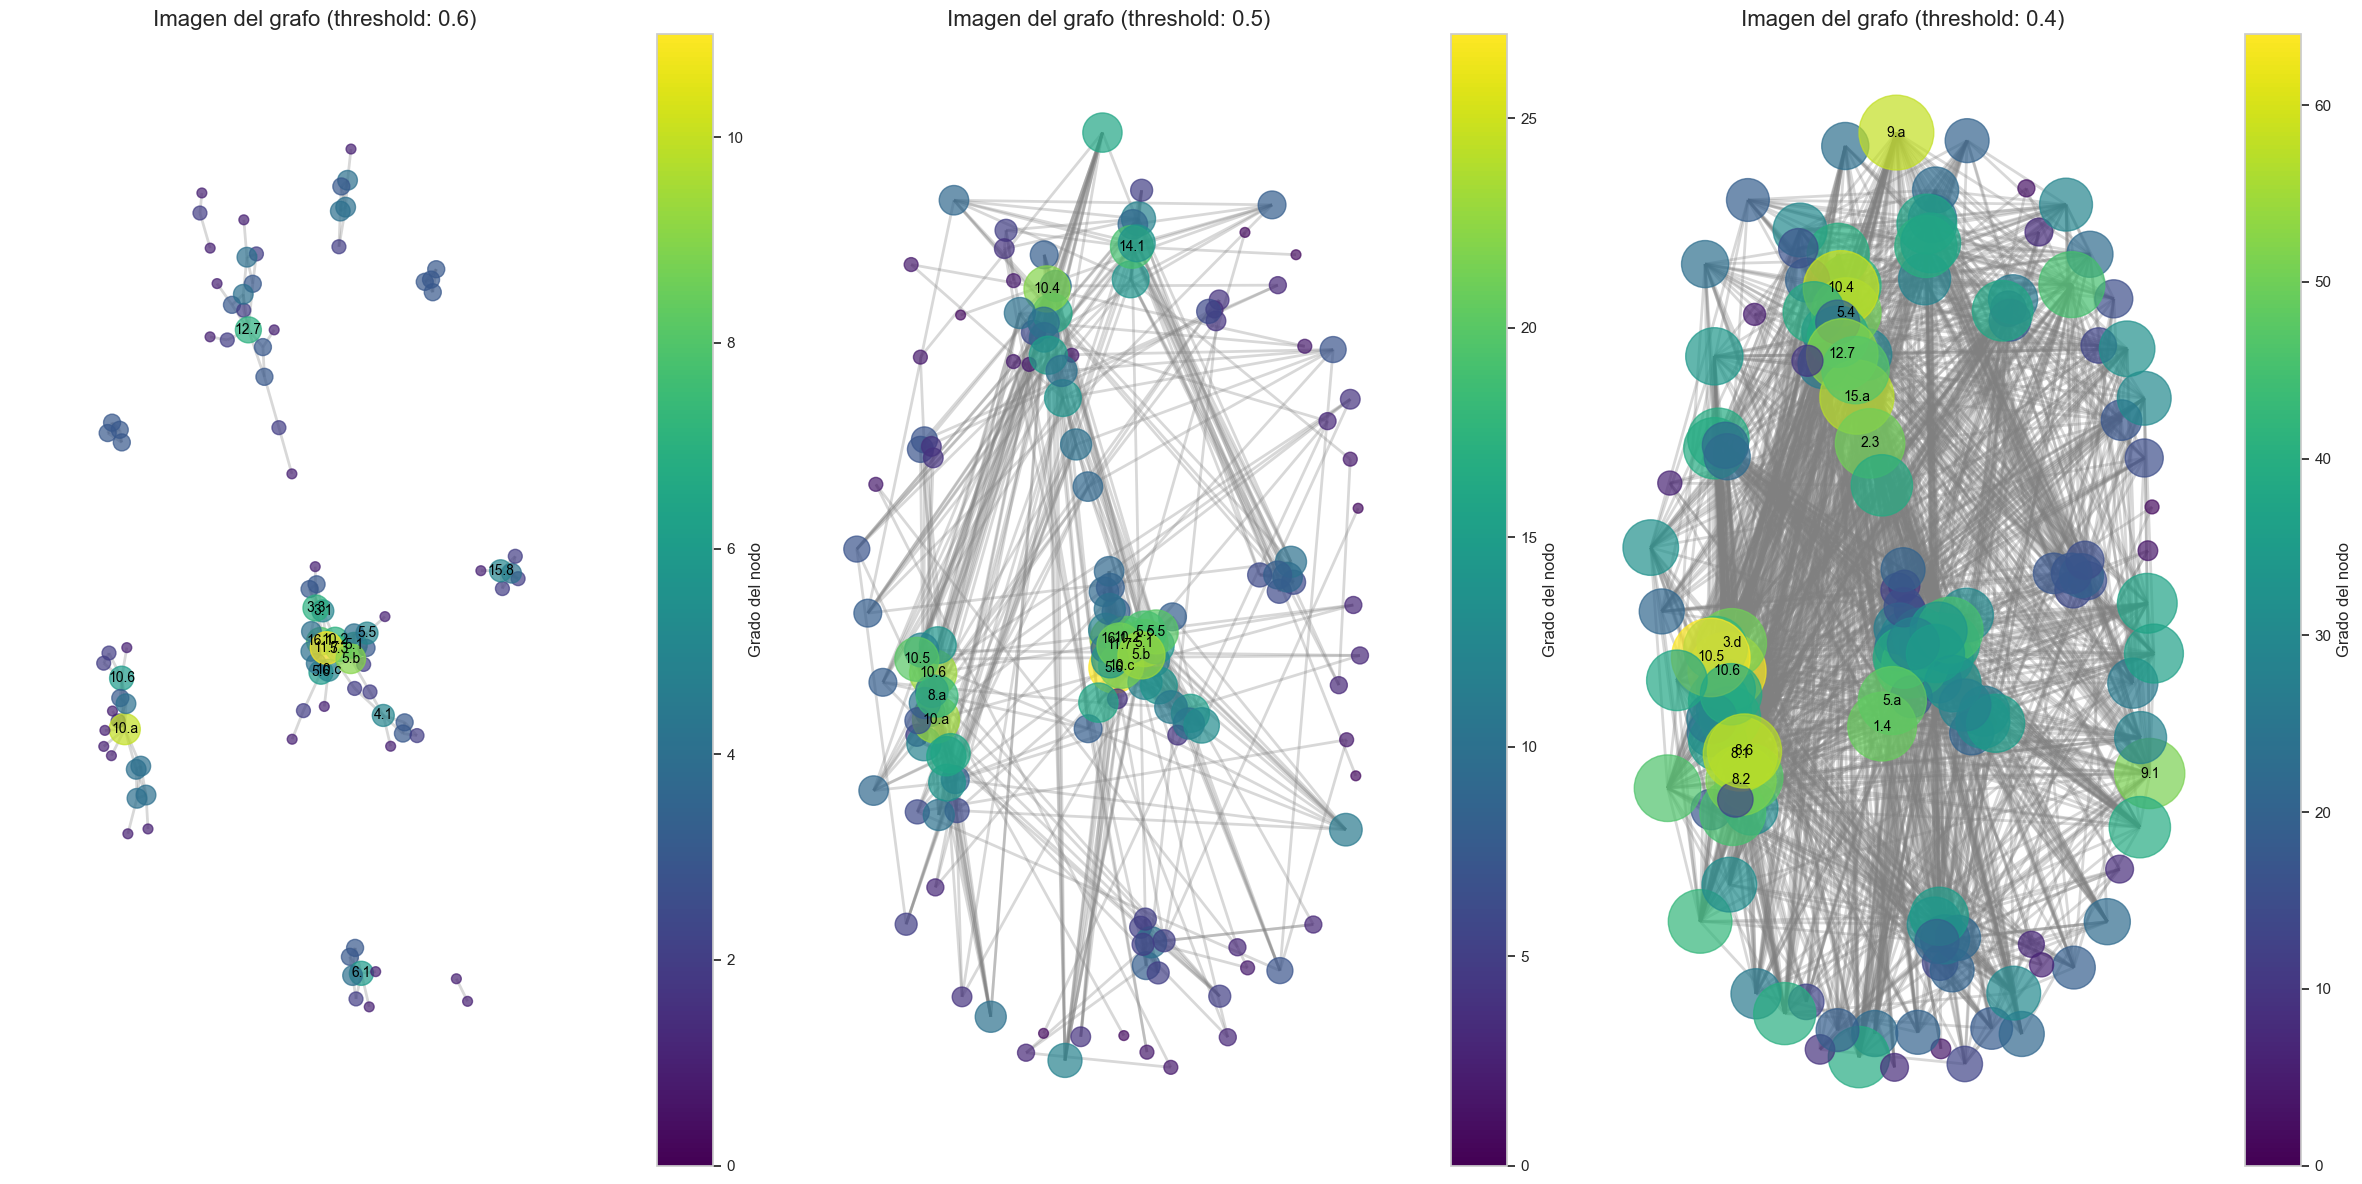

In [24]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # Para mejorar la estética de los gráficos
import re  # Para expresiones regulares
import community as community_louvain  # Para el algoritmo Louvain
import leidenalg  # Para el algoritmo Leiden
import igraph as ig  # Backend para Leiden
from collections import defaultdict
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Configuración de estilo de Seaborn para mejores gráficos
sns.set(style="whitegrid")

# ==========================================
# Paso 1: Cargar la matriz de similitud desde el archivo CSV
# ==========================================
df = pd.read_csv('data/nuevo_dataframe.csv', index_col=0)

# ==========================================
# Paso 1.1: Filtrar nodos que pertenecen al objetivo 17
# ==========================================
# Definir el patrón para los nodos a eliminar
patron = r'^17\.[A-Za-z0-9]'

# Identificar los nodos que coinciden con el patrón
nodos_a_eliminar = df.index[df.index.str.match(patron)]

# Eliminar los nodos de las filas y columnas
df = df.drop(nodos_a_eliminar, axis=0)
df = df.drop(nodos_a_eliminar, axis=1)

# ==========================================
# Paso 2: Definir los umbrales con claves numéricas
# ==========================================
thresholds = {
    1: 0.4,
    2: 0.5,
    3: 0.6
}

# Ordenar los umbrales de mayor a menor para revertir el orden de los plots
thresholds_ordenados = dict(sorted(thresholds.items(), key=lambda item: item[1], reverse=True))

# Nombre del grafo
nombre_grafo = "Imagen del grafo"

# ==========================================
# Paso 3: Crear los grafos para cada umbral
# ==========================================
grafos = {}
for clave, umbral in thresholds_ordenados.items():
    # Crear un grafo vacío
    G = nx.Graph()
    
    # Añadir nodos
    G.add_nodes_from(df.index)
    
    # Añadir aristas basadas en el umbral
    # Iterar sobre la matriz de similitud
    for i in df.index:
        for j in df.columns:
            if i != j:
                similitud = df.at[i, j]
                if similitud >= umbral:
                    G.add_edge(i, j, weight=1)
    
    grafos[clave] = G

# ==========================================
# Paso 4: Definir una posición para los nodos
# ==========================================
# Usaremos un layout que distribuye mejor los nodos en grafos grandes
# Usamos el primer grafo (mayor umbral) para definir las posiciones
pos = nx.spring_layout(grafos[next(iter(grafos))], seed=42, k=0.1, iterations=50)

# ==========================================
# Paso 5: Configurar la figura para contener los subgráficos de los grafos
# ==========================================
fig_grafos, axes_grafos = plt.subplots(1, 3, figsize=(24, 12))

# ==========================================
# Paso 6: Dibujar cada grafo en su propio subgráfico
# ==========================================
for ax, (clave, G) in zip(axes_grafos, grafos.items()):
    # Calcular el grado de cada nodo
    grados = dict(G.degree())
    
    # Normalizar los grados para el tamaño de los nodos
    node_sizes = [v * 50 for v in grados.values()]
    
    # Dibujar nodos
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=node_sizes,
        node_color=list(grados.values()),
        cmap=plt.cm.viridis,
        alpha=0.7
    )
    
    # Dibujar aristas
    edges = G.edges(data=True)
    # Normalizar los pesos para el grosor de las aristas
    edge_widths = [edata['weight'] * 2 for _, _, edata in edges]
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edgelist=edges,
        width=edge_widths,
        alpha=0.3,
        edge_color='gray'
    )
    
    # Añadir una barra de colores para los nodos
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                               norm=plt.Normalize(vmin=min(grados.values()), vmax=max(grados.values())))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Grado del nodo')
    
    # Mostrar etiquetas solo para nodos con grado alto (percentil 90)
    umbral_grado = pd.Series(grados).quantile(0.9)
    etiquetas = {n: n for n, d in grados.items() if d >= umbral_grado}
    nx.draw_networkx_labels(
        G, pos, ax=ax,
        labels=etiquetas,
        font_size=10,
        font_color='black'
    )
    
    # Título del subgráfico con el formato deseado
    ax.set_title(f'{nombre_grafo} (threshold: {thresholds_ordenados[clave]})', fontsize=16)
    
    # Eliminar los ejes
    ax.set_axis_off()

# Ajustar el layout y mostrar la figura de los grafos
plt.tight_layout()
plt.show()


Leiden y Louvain han detectado las mismas comunidades. Se tratarán como 'Leiden/Louvain'.



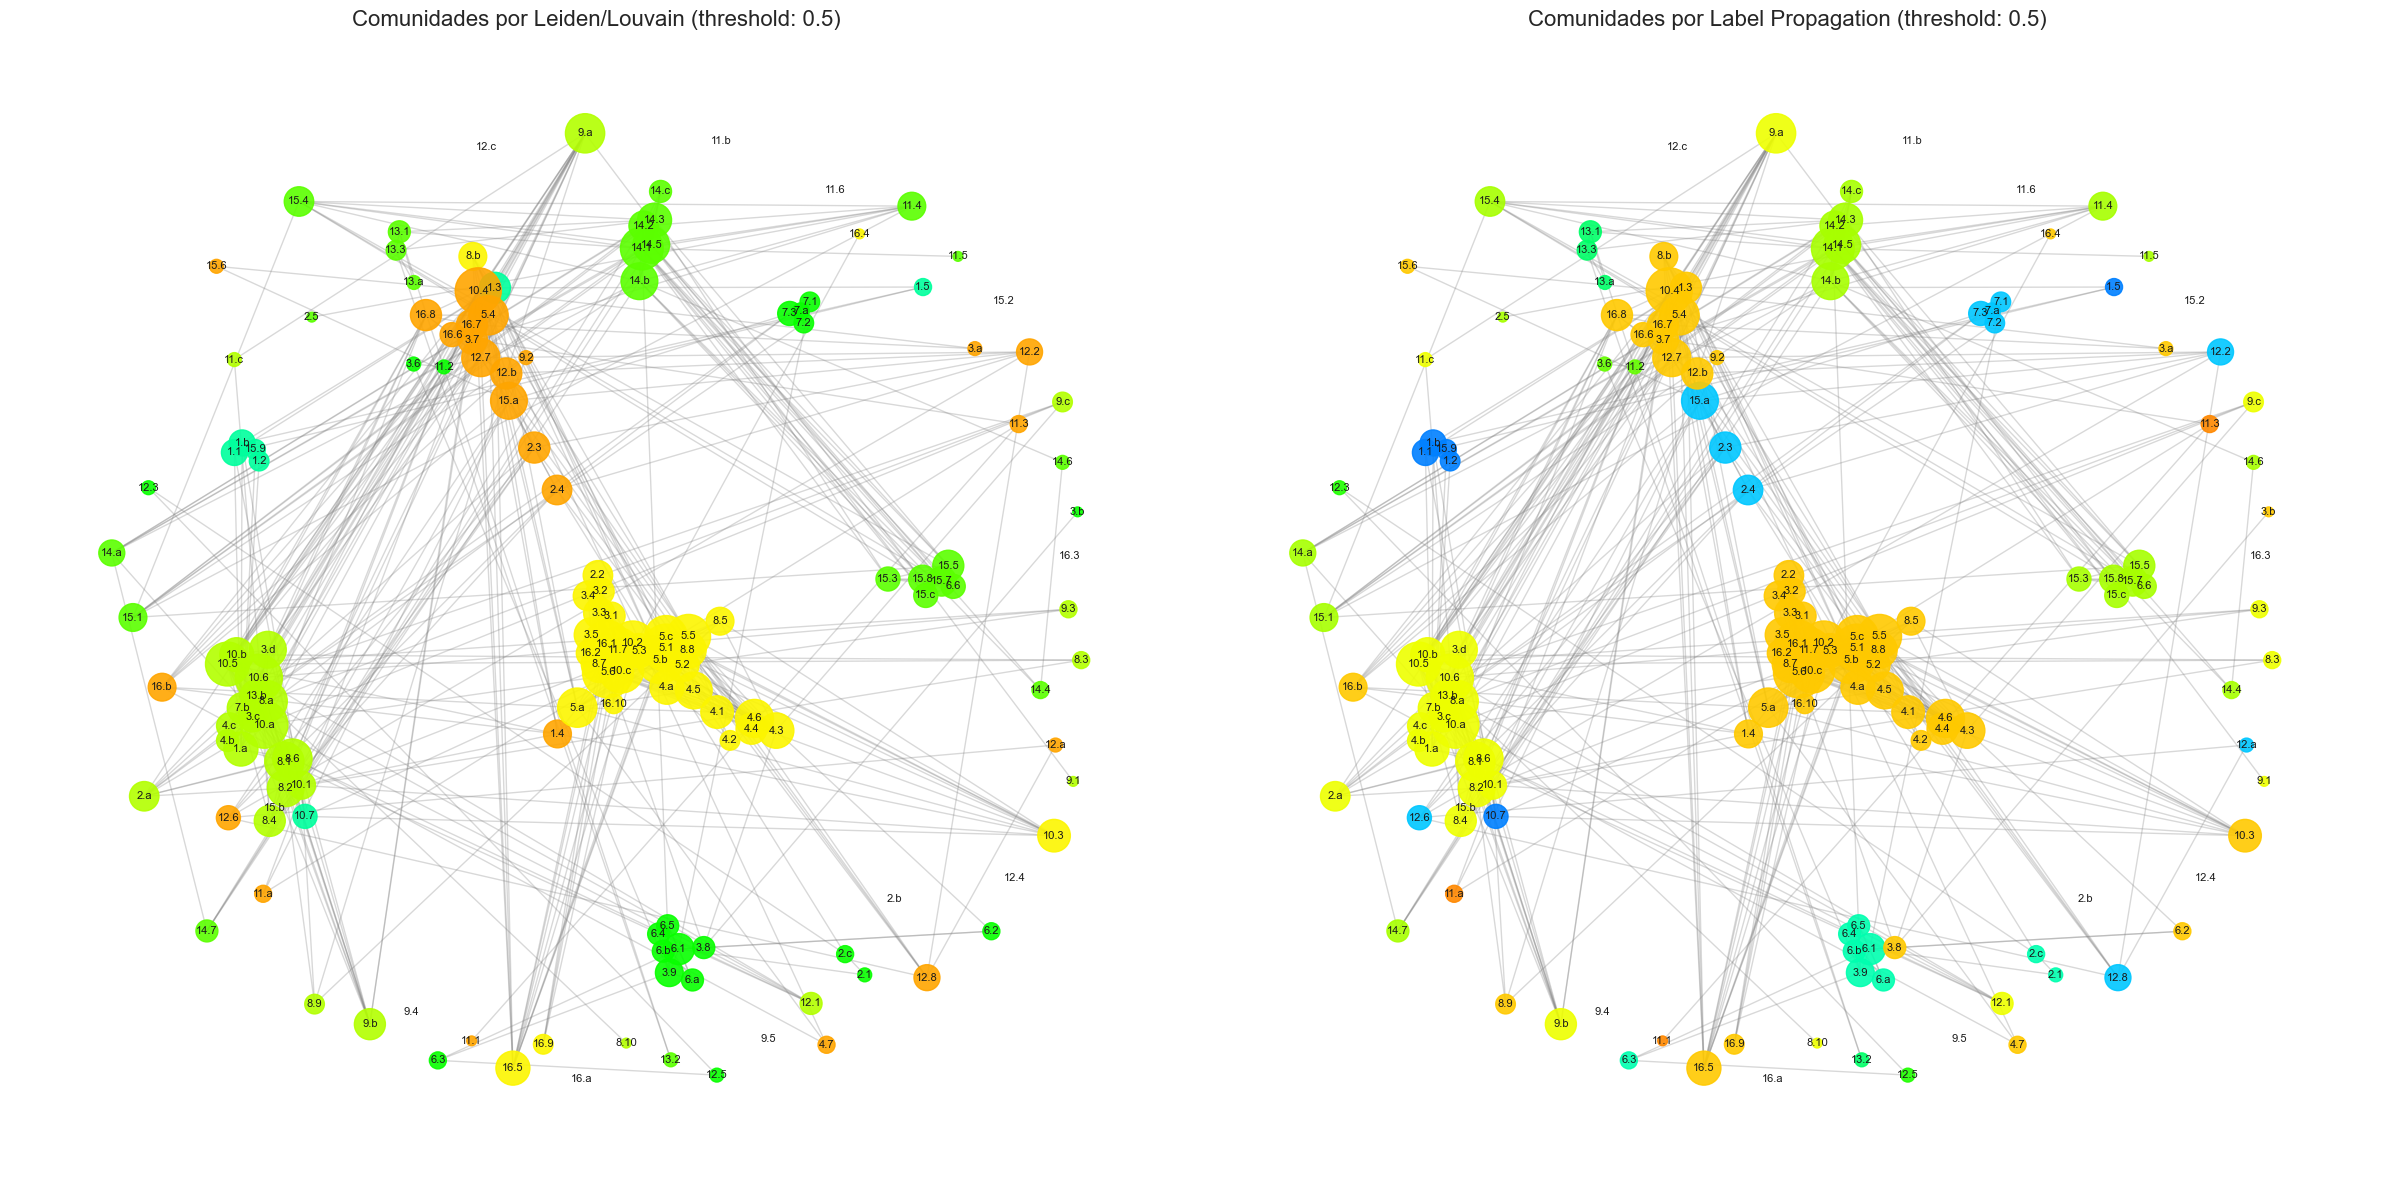

===== Resumen de Comunidades Detectadas =====

===== Leiden/Louvain =====
Cantidad de comunidades: 17
Tamaños de las comunidades (de mayor a menor): [35, 28, 25, 24, 20, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Comunidades con más de un nodo (6):
Comunidad 1 (24 nodos): 11.3, 15.6, 16.6, 9.2, 12.8, 3.a, 12.6, 12.2, 11.1, 15.a, 5.4, 4.7, 10.4, 11.a, 3.7, 16.8, 16.7, 12.7, 1.4, 12.b, 2.3, 2.4, 16.b, 12.a
Comunidad 2 (35 nodos): 5.2, 5.6, 4.a, 16.9, 16.1, 16.2, 4.6, 10.c, 8.b, 16.4, 16.5, 3.1, 3.4, 4.2, 4.4, 16.10, 5.1, 10.3, 3.2, 3.5, 8.8, 5.3, 2.2, 10.2, 8.5, 8.7, 3.3, 5.5, 5.c, 4.3, 4.5, 4.1, 11.7, 5.b, 5.a
Comunidad 3 (28 nodos): 3.c, 4.b, 1.a, 9.c, 10.6, 10.a, 13.b, 8.3, 7.b, 8.9, 3.d, 9.b, 10.1, 9.1, 8.10, 2.a, 4.c, 10.b, 8.4, 10.5, 12.1, 8.2, 8.1, 9.3, 8.a, 9.a, 8.6, 11.c
Comunidad 4 (25 nodos): 15.c, 6.6, 14.4, 15.3, 13.1, 13.2, 14.3, 15.7, 15.4, 15.5, 13.a, 14.7, 13.3, 14.a, 14.c, 15.1, 15.8, 14.b, 11.5, 14.6, 14.2, 11.4, 14.1, 14.5, 2.5
Comunidad 5 (20 nodos): 11.2, 12.5, 6.4, 6.3, 

In [25]:
# ==========================================
# Paso 7: Análisis de Comunidades para threshold = 0.5
# ==========================================
# Seleccionar el grafo con threshold = 0.5
clave_threshold_0_5 = [clave for clave, umbral in thresholds_ordenados.items() if umbral == 0.5][0]
G_threshold_0_5 = grafos[clave_threshold_0_5]

# ==========================================
# Paso 8: Aplicar dos algoritmos de detección de comunidades (Leiden/Louvain y Label Propagation)
# ==========================================

# 8.1: Algoritmo Louvain
partition_louvain = community_louvain.best_partition(G_threshold_0_5)

# Convertir la partición a un formato de comunidades
def partition_to_comunidades(partition):
    comunidades = defaultdict(list)
    for nodo, comunidad in partition.items():
        comunidades[comunidad].append(nodo)
    return list(comunidades.values())

comunidades_louvain = partition_to_comunidades(partition_louvain)

# 8.2: Algoritmo Leiden
# Convertir NetworkX Graph a igraph Graph
def nx_to_igraph(G):
    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    edges = [(mapping[u], mapping[v]) for u, v in G.edges()]
    ig_G = ig.Graph(edges=edges, directed=False)
    ig_G.vs["name"] = list(G.nodes())
    return ig_G

ig_G = nx_to_igraph(G_threshold_0_5)

# Aplicar el algoritmo Leiden
partition_leiden = leidenalg.find_partition(ig_G, leidenalg.ModularityVertexPartition)

# Convertir la partición a un formato de comunidades con nombres de nodos
comunidades_leiden = [ [ig_G.vs[vertex]['name'] for vertex in comunidad] for comunidad in partition_leiden ]

# Verificar si Leiden y Louvain producen las mismas comunidades
def comunidades_iguales(com1, com2):
    # Convertir listas de comunidades a conjuntos de conjuntos
    set_com1 = set(frozenset(c) for c in com1)
    set_com2 = set(frozenset(c) for c in com2)
    return set_com1 == set_com2

iguales = comunidades_iguales(comunidades_louvain, comunidades_leiden)

if iguales:
    print("Leiden y Louvain han detectado las mismas comunidades. Se tratarán como 'Leiden/Louvain'.\n")
    comunidades_leiden_louvain = comunidades_louvain  # Usar una de las dos
else:
    print("Leiden y Louvain han detectado comunidades diferentes. Se utilizará únicamente Leiden para el análisis.\n")
    comunidades_leiden_louvain = comunidades_leiden

# 8.3: Algoritmo Label Propagation
comunidades_label = list(nx.algorithms.community.label_propagation_communities(G_threshold_0_5))
comunidades_label = [list(comunidad) for comunidad in comunidades_label]

# ==========================================
# Paso 9: Asignar colores a las comunidades
# ==========================================

def asignar_colores(comunidades):
    """
    Asigna un color único a cada comunidad.
    """
    colores = sns.color_palette('hsv', len(comunidades))
    color_map = {}
    for comunidad, color in zip(comunidades, colores):
        for nodo in comunidad:
            color_map[nodo] = color
    return color_map

# Asignar colores para Leiden/Louvain
color_map_leiden_louvain = asignar_colores(comunidades_leiden_louvain)

# Asignar colores para Label Propagation
color_map_label = asignar_colores(comunidades_label)

# Crear listas de colores para los nodos según su comunidad
node_colors_leiden_louvain = [color_map_leiden_louvain[nodo] for nodo in G_threshold_0_5.nodes()]
node_colors_label = [color_map_label[nodo] for nodo in G_threshold_0_5.nodes()]

# ==========================================
# Paso 10: Visualizar las Comunidades Detectadas por Ambos Algoritmos
# ==========================================
fig_comunidades, axes_comunidades = plt.subplots(1, 2, figsize=(24, 12))

# 10.1: Visualización Leiden/Louvain
axes_comunidades[0].set_title('Comunidades por Leiden/Louvain (threshold: 0.5)', fontsize=16)
nx.draw_networkx_edges(G_threshold_0_5, pos, ax=axes_comunidades[0], alpha=0.3, edge_color='gray')
nodes_leiden_louvain = nx.draw_networkx_nodes(
    G_threshold_0_5, pos,
    ax=axes_comunidades[0],
    node_color=node_colors_leiden_louvain,
    node_size=[v * 50 for v in dict(G_threshold_0_5.degree()).values()],
    alpha=0.9
)
nx.draw_networkx_labels(
    G_threshold_0_5, pos,
    ax=axes_comunidades[0],
    labels={n: n for n in G_threshold_0_5.nodes()},
    font_size=8
)
axes_comunidades[0].axis('off')

# 10.2: Visualización Label Propagation
axes_comunidades[1].set_title('Comunidades por Label Propagation (threshold: 0.5)', fontsize=16)
nx.draw_networkx_edges(G_threshold_0_5, pos, ax=axes_comunidades[1], alpha=0.3, edge_color='gray')
nodes_label = nx.draw_networkx_nodes(
    G_threshold_0_5, pos,
    ax=axes_comunidades[1],
    node_color=node_colors_label,
    node_size=[v * 50 for v in dict(G_threshold_0_5.degree()).values()],
    alpha=0.9
)
nx.draw_networkx_labels(
    G_threshold_0_5, pos,
    ax=axes_comunidades[1],
    labels={n: n for n in G_threshold_0_5.nodes()},
    font_size=8
)
axes_comunidades[1].axis('off')

plt.tight_layout()
plt.show()

# ==========================================
# Paso 11: Resumen de Comunidades Detectadas por Cada Algoritmo
# ==========================================

def resumen_comunidades(comunidades, nombre_algoritmo):
    """
    Imprime el resumen de comunidades:
    - Cantidad de comunidades detectadas.
    - Tamaño de todas las comunidades ordenadas de mayor a menor.
    - Lista de comunidades con más de un nodo.
    - Para todas las comunidades con 3 nodos o más, verifica si hay un objetivo dominante.
    """
    cantidad = len(comunidades)
    tamaños = sorted([len(comunidad) for comunidad in comunidades], reverse=True)
    print(f"===== {nombre_algoritmo} =====")
    print(f"Cantidad de comunidades: {cantidad}")
    print(f"Tamaños de las comunidades (de mayor a menor): {tamaños}\n")
    
    # Listar comunidades con más de un nodo
    comunidades_multi = [com for com in comunidades if len(com) > 1]
    print(f"Comunidades con más de un nodo ({len(comunidades_multi)}):")
    for idx, comunidad in enumerate(comunidades_multi, 1):
        print(f"Comunidad {idx} ({len(comunidad)} nodos): {', '.join(comunidad)}")
    print("\n")
    
    # Analizar todas las comunidades con 3 nodos o más
    print(f"Análisis de comunidades con 3 nodos o más en {nombre_algoritmo}:")
    for idx, comunidad in enumerate(comunidades, 1):
        if len(comunidad) < 3:
            continue
        
        # Suponemos que el objetivo está antes del punto en el nombre del nodo, por ejemplo, '12.a'
        objetivos = [re.match(r'^(\d+)\.', nodo).group(1) for nodo in comunidad if re.match(r'^(\d+)\.', nodo)]
        
        if not objetivos:
            print(f"Comunidad {idx} ({len(comunidad)} nodos): No se pudo identificar el objetivo dominante.")
            continue
        
        objetivo_counts = pd.Series(objetivos).value_counts()
        objetivo_dominante = objetivo_counts.idxmax()
        cantidad_dominante = objetivo_counts.max()
        porcentaje = (cantidad_dominante / len(comunidad)) * 100
        print(f"Comunidad {idx} ({len(comunidad)} nodos): Objetivo dominante {objetivo_dominante} ({cantidad_dominante} nodos, {porcentaje:.2f}%)")
    print("\n")

print("===== Resumen de Comunidades Detectadas =====\n")

# Resumen para Leiden/Louvain
resumen_comunidades(comunidades_leiden_louvain, "Leiden/Louvain")

# Resumen para Label Propagation
resumen_comunidades(comunidades_label, "Label Propagation")

# ==========================================
# Paso 12: Verificar Si Algún Algoritmo Produce el Mismo Resultado
# ==========================================

# Dado que ahora solo tenemos dos algoritmos: Leiden/Louvain y Label Propagation,
# podemos verificar si detectan las mismas comunidades.

def comunidades_iguales(com1, com2):
    """
    Compara dos listas de comunidades y retorna True si son iguales, False en caso contrario.
    """
    # Convertir listas de comunidades a conjuntos de conjuntos
    set_com1 = set(frozenset(c) for c in com1)
    set_com2 = set(frozenset(c) for c in com2)
    return set_com1 == set_com2

igualdad = comunidades_iguales(comunidades_leiden_louvain, comunidades_label)
estado = "Mismas comunidades" if igualdad else "Comunidades diferentes"
print("===== Comparación de Comunidades Entre Algoritmos =====\n")
print(f"Leiden/Louvain vs Label Propagation: {estado}")